# 📓 Notebook - Teori & Praktik Bab 9: Unsupervised Learning

Sebagian besar data di dunia ini **tidak berlabel**. Melabeli data itu mahal dan memakan waktu. Oleh karena itu, Unsupervised Learning (Pembelajaran Tak Terawasi) memiliki potensi yang sangat besar.

Dalam bab ini, kita akan membahas dua teknik utama:
1.  **Clustering (K-Means & DBSCAN):** Mengelompokkan data yang mirip ke dalam cluster.
2.  **Gaussian Mixtures:** Model probabilistik yang mengasumsikan data dihasilkan dari campuran beberapa distribusi Gaussian (Normal).

Aplikasi: Segmentasi pelanggan, analisis citra, deteksi anomali/fraud, dan pengurangan dimensi.

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

def plot_decision_boundaries(clf, X):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000),
                         np.linspace(mins[1], maxs[1], 1000))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_clusters(X)

## 1. K-Means Clustering

### Teori: Centroid dan Inersia
K-Means adalah algoritma clustering yang sederhana dan efisien. Idenya adalah menemukan sejumlah $k$ pusat cluster (**centroids**) dan menugaskan setiap titik data ke centroid terdekatnya.

Algoritma bekerja secara iteratif:
1.  Pilih $k$ centroid secara acak.
2.  Tugaskan setiap instance ke centroid terdekat.
3.  Perbarui posisi centroid ke rata-rata (mean) dari instance yang ditugaskan padanya.
4.  Ulangi langkah 2 & 3 sampai posisi centroid tidak berubah (konvergen).

K-Means berusaha meminimalkan **Inersia**, yaitu jarak rata-rata kuadrat antara setiap instance dan centroid terdekatnya.

Cluster Centers (Centroids):
 [[-6.68630691 -6.81139455]
 [ 2.03639615  4.26762858]
 [-2.50265159  9.03963769]
 [-8.80798056  7.40425704]
 [ 4.66534309  1.87476184]]


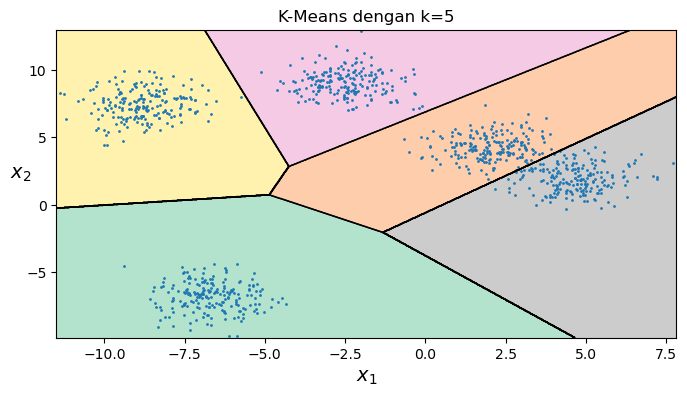

In [ ]:
from sklearn.cluster import KMeans

# dataset sintetis (blobs)
X, y = make_blobs(n_samples=1000, centers=5, n_features=2, random_state=42)

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X)

print("Cluster Centers (Centroids):\n", kmeans.cluster_centers_)

# Visualisasi Batas Keputusan (Voronoi Diagram)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.title(f"K-Means dengan k={k}")
plt.show()

## 2. Menentukan Jumlah Cluster Optimal ($k$)

### Teori: Metode Siku (Elbow) & Silhouette Score
Salah satu tantangan K-Means adalah kita harus menentukan $k$ di awal. Bagaimana jika kita tidak tahu berapa banyak cluster yang ada?

1.  **Metode Elbow:** Plot inersia sebagai fungsi dari $k$. Saat $k$ bertambah, inersia akan turun. Titik di mana penurunan inersia mulai melambat secara drastis (membentuk siku) seringkali merupakan $k$ yang baik.
2.  **Silhouette Score:** Mengukur seberapa mirip sebuah objek dengan clusternya sendiri dibandingkan dengan cluster lain. Nilai berkisar dari -1 (salah cluster) hingga +1 (sangat baik). Kita mencari nilai rata-rata silhouette tertinggi.

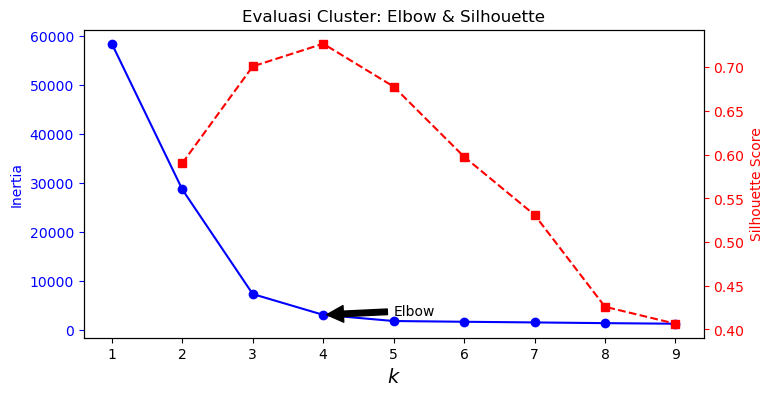

In [ ]:
from sklearn.metrics import silhouette_score

kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot Inersia (Elbow Method)
ax1.plot(range(1, 10), inertias, "bo-")
ax1.set_xlabel("$k$", fontsize=14)
ax1.set_ylabel("Inertia", color="b")
ax1.tick_params('y', colors='b')
ax1.annotate('Elbow', xy=(4, inertias[3]), xytext=(5, 3000),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Plot Silhouette Score (sumbu kanan)
ax2 = ax1.twinx()
ax2.plot(range(2, 10), silhouette_scores, "rs--")
ax2.set_ylabel("Silhouette Score", color="r")
ax2.tick_params('y', colors='r')

plt.title("Evaluasi Cluster: Elbow & Silhouette")
plt.show()

# Inersia turun drastis di k=4 atau k=5.
# Silhouette score tertinggi ada di k=4 dan k=5. Ini mengonfirmasi bahwa 5 adalah pilihan yang baik.

## 3. Batasan K-Means

### Teori
K-Means bekerja sangat baik jika cluster berbentuk bulat (spherical) dan memiliki kepadatan yang sama. Namun, ia **gagal** jika:
1.  Cluster memiliki bentuk non-linear (seperti bulan sabit).
2.  Cluster memiliki kepadatan yang sangat berbeda.
3.  Cluster memiliki ukuran yang sangat berbeda (anisotropic).

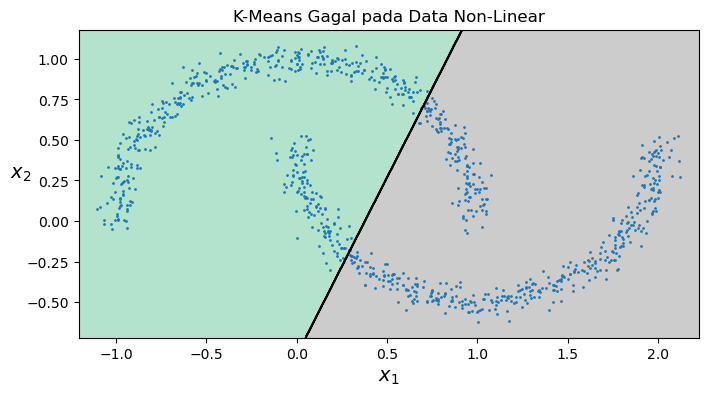

In [4]:
# Contoh K-Means gagal pada data Moons
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)
kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init=10)
y_pred_moons = kmeans_moons.fit_predict(X_moons)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_moons, X_moons)
plt.title("K-Means Gagal pada Data Non-Linear")
plt.show()

## 4. DBSCAN (Density-Based Spatial Clustering)

### Teori
DBSCAN mendefinisikan cluster sebagai area dengan **kepadatan tinggi** yang dipisahkan oleh area dengan kepadatan rendah. Ia memiliki dua parameter utama:
* `eps` (epsilon): Jarak maksimum antara dua sampel agar dianggap bertetangga.
* `min_samples`: Jumlah sampel minimum dalam radius `eps` agar sebuah titik dianggap sebagai "Core Point".

Kelebihan DBSCAN:
1.  Bisa menemukan cluster dengan bentuk apa pun (termasuk non-linear).
2.  Bisa mendeteksi **outlier/noise** (titik yang berada di daerah kepadatan rendah).
3.  Tidak perlu menentukan jumlah cluster ($k$) di awal.

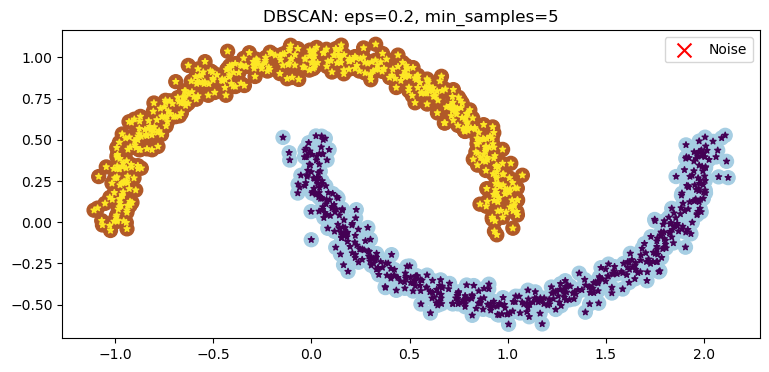

In [ ]:
from sklearn.cluster import DBSCAN

# Menggunakan DBSCAN pada data Moons yang gagal dikerjakan K-Means
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X_moons)

# Visualisasi
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1 # Label -1 berarti anomali/noise
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1], c="r", marker="x", s=100, label="Noise")
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.title(f"DBSCAN: eps={dbscan.eps}, min_samples={dbscan.min_samples}")
    plt.legend()

plt.figure(figsize=(9, 4))
plot_dbscan(dbscan, X_moons, size=100)
plt.show()

# DBSCAN berhasil memisahkan dua bentuk bulan sabit dengan sempurna dan mendeteksi beberapa noise (silang merah).

## 5. Gaussian Mixtures (GMM)

### Teori: Soft Clustering & Probabilitas
Gaussian Mixture Model (GMM) adalah model probabilistik yang mengasumsikan bahwa data dihasilkan dari campuran sejumlah distribusi Gaussian (kurva lonceng) dengan parameter yang tidak diketahui (rata-rata dan varians).

Berbeda dengan K-Means (Hard Clustering) yang memaksa setiap titik masuk ke satu cluster, GMM memberikan **Soft Clustering**: probabilitas setiap titik termasuk dalam setiap cluster.

GMM sangat fleksibel karena bisa menyesuaikan bentuk cluster menjadi elips (bukan hanya bola seperti K-Means).

Probabilitas instans pertama masuk ke tiap cluster:
[[0.    0.002 0.    0.    0.998]]


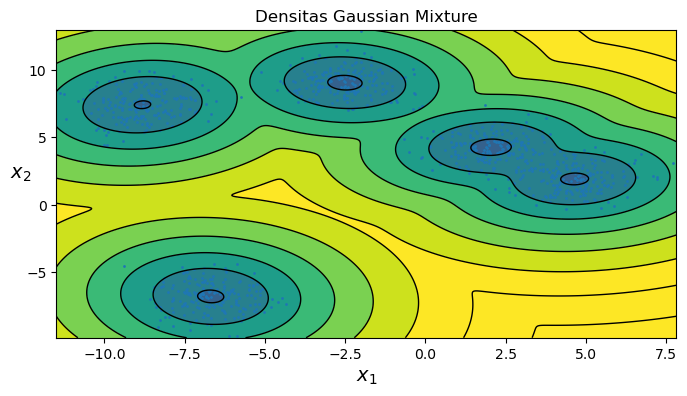

In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=5, n_init=10, random_state=42)
gm.fit(X)

# Prediksi Hard Clustering
y_pred_hard = gm.predict(X)

# Prediksi Soft Clustering (Probabilitas)
print("Probabilitas instans pertama masuk ke tiap cluster:")
print(np.round(gm.predict_proba(X[:1]), 3))

def plot_gaussian_mixture(clusterer, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, norm=plt.cm.colors.LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z, norm=plt.cm.colors.LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12), linewidths=1, colors='k')
    plot_clusters(X)

plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.title("Densitas Gaussian Mixture")
plt.show()

### Deteksi Anomali dengan GMM

**Teori**
GMM dapat digunakan untuk deteksi anomali. Idenya: instance yang berada di daerah dengan **kepadatan rendah** (low density) kemungkinan besar adalah anomali.

Kita bisa menggunakan metode `score_samples()` untuk mendapatkan log kepadatan (log-likelihood) dari setiap instance. Instance dengan skor terendah adalah anomali.

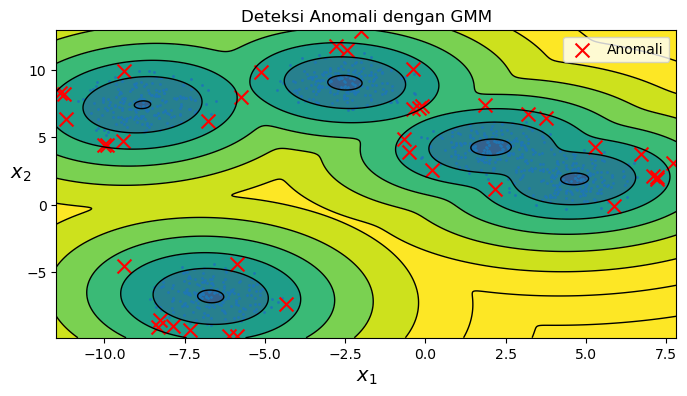

In [ ]:
# Hitung log-likelihood density
densities = gm.score_samples(X)

density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='x', s=100, label='Anomali')
plt.title("Deteksi Anomali dengan GMM")
plt.legend()
plt.show()

## Kesimpulan Bab 9

1.  **K-Means:** Cepat, sederhana, tapi butuh $k$ ditentukan dan hanya bagus untuk cluster bulat.
2.  **DBSCAN:** Bagus untuk bentuk aneh dan deteksi noise, tapi sensitif terhadap parameter kepadatan.
3.  **Gaussian Mixtures:** Model probabilistik yang fleksibel, bagus untuk estimasi densitas dan deteksi anomali, tapi bisa lambat dan konvergen ke solusi lokal.